<a href="https://colab.research.google.com/github/Rachel1809/Toxic-Classification/blob/main/Toxic_comment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# 1. Import libraries and load data

In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.metrics import CategoricalAccuracy

In [ ]:
df = pd.read_csv(os.path.join("/content/drive/MyDrive/ColabNotebooks/data", "train.csv"))

In [ ]:
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


# 2. Preprocessing

## 2.1. Data overview

In [ ]:
df[df.columns[2:]]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
159566,0,0,0,0,0,0
159567,0,0,0,0,0,0
159568,0,0,0,0,0,0
159569,0,0,0,0,0,0


In [ ]:
df.loc[df.iloc[:, 2]==1].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


In [ ]:
df.iloc[12].comment_text

'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'

## 2.2. Data preprocessing

In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [ ]:
X = df.comment_text
y = df.iloc[:,2:].values

In [ ]:
# number of words in vocab
MAX_VOCAB = 200000

In [ ]:
vectorizer = TextVectorization(max_tokens=MAX_VOCAB, 
                               output_sequence_length=1800, 
                               output_mode='int')

In [ ]:
vectorizer.adapt(X.values)

In [ ]:
vectorizer('Hello world, welcome to this project')[:6]

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([288, 263, 191,   3,  14, 463])>

In [ ]:
processed_text = vectorizer(X.values)

In [ ]:
processed_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [ ]:
# MCSHBAP - map, cache, shuffle, batch, prefetch
# from_tensor_slices OR list_file
data = tf.data.Dataset.from_tensor_slices((processed_text, y))
data = data.cache()
data = data.shuffle(160000)
data = data.batch(16)
data = data.prefetch(8) # prevent bottleneck

In [ ]:
batch_X, batch_y = data.as_numpy_iterator().next()

In [ ]:
batch_X.shape

(16, 1800)

In [ ]:
train = data.take(int(len(data) * .7))
val = data.skip(int(len(data) * .7)).take(int(len(data)*.2))
test = data.take(int(len(data) * .9)).take(int(len(data)*.1))

In [ ]:
len(train)

6981

In [ ]:
train.as_numpy_iterator().next()

(array([[  265,     3,  1409, ...,     0,     0,     0],
        [18630,   113,     4, ...,     0,     0,     0],
        [    9,  4419,   130, ...,     0,     0,     0],
        ...,
        [   46,  1377,    31, ...,     0,     0,     0],
        [ 1818,   979,   204, ...,     0,     0,     0],
        [ 1458,    42,     8, ...,     0,     0,     0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

# 3. Buiding model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
model = Sequential()
model.add(Embedding(MAX_VOCAB + 1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics=CategoricalAccuracy())

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [ ]:
history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
6981/6981 [==============================] - 750s 107ms/step - loss: 0.0639 - categorical_accuracy: 0.9679 - val_loss: 0.0474 - val_categorical_accuracy: 0.9941
Epoch 2/5
6981/6981 [==============================] - 733s 105ms/step - loss: 0.0482 - categorical_accuracy: 0.9923 - val_loss: 0.0407 - val_categorical_accuracy: 0.9941
Epoch 3/5
6981/6981 [==============================] - 746s 107ms/step - loss: 0.0431 - categorical_accuracy: 0.9939 - val_loss: 0.0376 - val_categorical_accuracy: 0.9933
Epoch 4/5
6981/6981 [==============================] - 736s 105ms/step - loss: 0.0396 - categorical_accuracy: 0.9839 - val_loss: 0.0354 - val_categorical_accuracy: 0.9941
Epoch 5/5
6981/6981 [==============================] - 735s 105ms/step - loss: 0.0370 - categorical_accuracy: 0.9938 - val_loss: 0.0355 - val_categorical_accuracy: 0.9944


In [ ]:
import matplotlib.pyplot as plt

<Figure size 576x360 with 0 Axes>

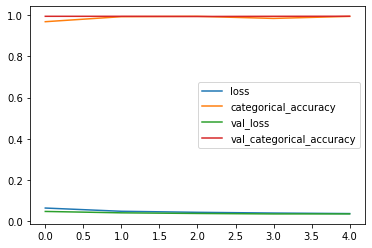

In [ ]:
plt.figure(figsize=(8, 5))
pd.DataFrame(history.history).plot()
plt.show()

# 4. Make predictions

In [ ]:
text = vectorizer("you suicide")
text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   7, 3326,    0, ...,    0,    0,    0])>

In [ ]:
np.expand_dims(text, 0)

In [ ]:
res = model.predict(np.expand_dims(text, 0))
res

array([[0.38126954, 0.00187431, 0.07203507, 0.0319345 , 0.13548407,
        0.06236345]], dtype=float32)

In [ ]:
df.columns[2:]

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
pred = (model.predict(batch_X) > 0.5).astype(int)
pred

In [ ]:
pred = pred.flatten()
pred

# 5. Evaluate model

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X_true, y_true = batch
    pred = model.predict(X_true)

    y_true = y_true.flatten()
    pred = pred.flatten()

    pre.update_state(y_true, pred)
    re.update_state(y_true, pred)
    acc.update_state(y_true, pred)

In [ ]:
print(f"Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}")

Precision: 0.8436431288719177, Recall: 0.7843930721282959, Accuracy: 0.48846539855003357


In [ ]:
model.save('toxic-detect.h5')

# 5. Test and Gradio

In [ ]:
!pip install gradio jinja2

In [ ]:
import gradio as gr

In [ ]:
model = tf.keras.models.load_model('toxic-detect.h5')

In [ ]:
def evaluate_comment(Comment):
    processed_Comment = vectorizer([Comment])
    res = model.predict(processed_Comment)

    text = ''
    for i, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, 'Violate' if res[0][i] > 0.5 else 'None')
    
    return text

In [ ]:
interface = gr.Interface(fn = evaluate_comment, 
                         inputs = gr.inputs.Textbox(lines = 4, placeholder='Comment to evaluate'), 
                         outputs = 'text')

In [ ]:
interface.launch(share=True)